<a href="https://colab.research.google.com/github/roo-21/facepainting-gan/blob/main/face_paint_vanillaGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GAN**
GANs are a type of generative model that excels at generating synthetic data that is similar to real data. The key idea behind GANs is to pit two neural networks, the generator and the discriminator, against each other in a two-player minimax game.

The generator network creates fake data, such as images or text, from random noise. The discriminator network, on the other hand, tries to distinguish between real data and the fake data produced by the generator. The generator's goal is to generate data that is so convincing that the discriminator can't tell it apart from real data, while the discriminator aims to improve its ability to differentiate between real and fake data.

## **The Dataset**
https://github.com/asahi417/wikiart-image-dataset

WikiArt is an online platform and digital repository dedicated to the world of visual arts. It serves as a comprehensive resource for art enthusiasts, students, researchers, and anyone interested in exploring and learning about art. The primary focus of WikiArt is to provide a vast collection of information about various artists, art movements, and individual artworks from different periods and styles.

WikiART Face is a collection of faces from paintings. Inspired by the largest human-face image set CelebA.

![](https://github.com/asahi417/wikiart-image-dataset/blob/master/assets/wikiart_face_image.png?raw=true)

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_visible_devices(gpus, 'GPU')

In [ ]:
images=np.load('/drive/MyDrive/Datasets/images/images.npy')
images=(images/127.5)-1
images.shape

(6200, 128, 128, 3)

In [ ]:
images_blur=np.load('/drive/MyDrive/Datasets/images/images_blurred.npy') #images where the face is kept un-blurred while everything else is blurred
images_blur=(images_blur/127.5)-1
images_blur.shape

(6095, 128, 128, 3)

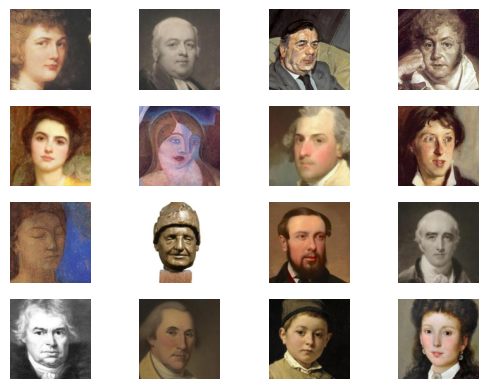

In [ ]:
i=0
for j in np.random.randint(0,images.shape[0],16):
    plt.subplot(4, 4,i+1)
    plt.imshow((images[j]+1)/2)
    plt.axis("off")
    i+=1
plt.show()

# GAN

In [ ]:
img_shape=images.shape[1:]
latent_dim=100  #size of the random array fed to generator as input. each such array generates a unique image
img_shape

(128, 128, 3)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout,Reshape,LeakyReLU
from keras.optimizers import Adam

In [ ]:
#The discriminator tries to distinguish between real and fake images
def create_discriminator(in_shape=img_shape):

  disc = Sequential()
  disc.add(Flatten(input_shape=in_shape))

  disc.add(Dense(512))
  disc.add(LeakyReLU(0.2))
  disc.add(Dropout(0.1))

  disc.add(Dense(256))
  disc.add(LeakyReLU(0.2))
  disc.add(Dropout(0.1))

  disc.add(Dense(1,activation='sigmoid'))

  disc.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.89),metrics=['accuracy'])

  return disc

In [ ]:
# The generator tries to make images that can fool the discriminator
def create_generator(latent_dim):

  noise_shape=(latent_dim,)

  gen=Sequential()

  gen.add(Dense(256, input_shape=noise_shape))
  gen.add(LeakyReLU(0.2))

  gen.add(Dense(512))
  gen.add(LeakyReLU(0.2))

  gen.add(Dense(1024))
  gen.add(LeakyReLU(0.2))

  gen.add(Dense(np.prod(img_shape),activation='tanh')) #final layer has the same no. of pixels as the image
                                                      #tanh is preferred over sigmoid as it is more stable and produce less noisy images
  gen.add(Reshape(img_shape)) #the layer is reshaped into image shape

  return gen

In [ ]:
def create_gan(generator, discriminator):
  discriminator.trainable = False

  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  model.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.89))
  return model

In [ ]:
# function that randomly selects images from both datasets such that 95% of the images are taken from the first dataset and the rest from the other
def real_samples(dataset1,dataset2,num_samples):
  idx1=np.random.randint(0,dataset1.shape[0],int(num_samples*0.95))
  idx2=np.random.randint(0,dataset2.shape[0],num_samples-int(num_samples*0.95))
  x1=dataset1[idx1]
  x2=dataset2[idx2]

  x=np.concatenate((x1,x2),axis=0)
  y=np.ones((num_samples,1))

  return x,y

In [ ]:
def generate_latent_points(latent_dim,num_samples):  #random noise that is fed into generator as input
  x_input = np.random.randn(num_samples,latent_dim)
  return x_input

In [ ]:
def generate_fake_samples(generator,latent_dim,num_samples):
  x_input=generate_latent_points(latent_dim,num_samples)
  x=generator.predict(x_input)
  y=np.zeros((num_samples,1))
  return x,y

In [ ]:
def train(g_model, d_model, gan_model, dataset1, dataset2, latent_dim, n_epochs=10,batch_size=32):

  batch_per_epoch=int(dataset1.shape[0]/batch_size)
  half_batch=int(batch_size/2)

  #lists to store discriminator and gan losses
  d_losses=[]
  g_losses=[]

  print(f"{n_epochs} epochs and {batch_per_epoch} batches of size {batch_size} each epoch")
  for i in range(n_epochs):
    for j in range(batch_per_epoch):

      x_real,y_real=real_samples(dataset1,dataset2,half_batch) # half the batch size of real images are taken during each batch and also they are labelled 1
      x_fake,y_fake=generate_fake_samples(g_model,latent_dim,half_batch) # half the batch size of fake images are taken as well and the are labelled 0
      x_train=np.concatenate((x_real,x_fake),axis=0) # the real and fake images are concatenated
      y_train=np.concatenate((y_real,y_fake),axis=0) # and the labels too

      idx=np.random.permutation(x_train.shape[0]) # taking indices of the image array in random order
      x_train=x_train[idx] #shuffling the images and labels using the above order
      y_train=y_train[idx]

      d_loss,_=d_model.train_on_batch(x_train,y_train) #training the discriminator

      x_gan = generate_latent_points(latent_dim,batch_size) # latent vectors are generated for the gan model
      y_gan=np.ones((batch_size,1)) #they are all labelled 1

      g_loss = gan_model.train_on_batch(x_gan,y_gan) #training gan using the above data

      print('Epoch %d/%d, Batch %d/%d, d=%.3f g=%.3f' % (i+1, n_epochs, j+1, batch_per_epoch, d_loss, g_loss))

    # appending discriminator loss and generator loss to the list after each epoch
    d_losses.append(d_loss)
    g_losses.append(g_loss)

  g_model.save('face_painter1.h5')
  return d_losses,g_losses

In [ ]:
discriminator=create_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 512)               25166336  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [ ]:
generator=create_generator(latent_dim)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 49152)            

In [ ]:
vec0=np.random.randn(1,latent_dim)
img=generator.predict(vec0) # generating an image before training

1/1 [==============================] - 2s 2s/step


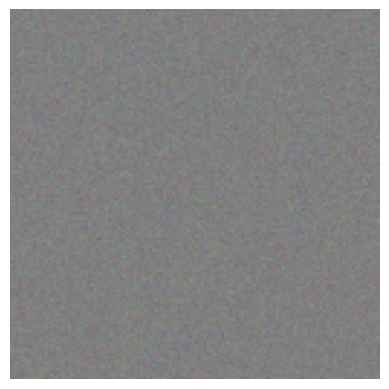

In [ ]:
plt.imshow((np.array(img[0])+1)/2)
plt.axis('off')
plt.show()

In [ ]:
gan=create_gan(generator,discriminator)

In [ ]:
epoch=200
batch_size=64

In [ ]:
d_loss,g_loss=train(generator,discriminator,gan,images,images_blur,latent_dim,epoch,batch_size)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Epoch 174/200, Batch 93/96, d=0.526 g=1.404
1/1 [==============================] - 0s 32ms/step
Epoch 174/200, Batch 94/96, d=0.476 g=1.542
1/1 [==============================] - 0s 22ms/step
Epoch 174/200, Batch 95/96, d=0.513 g=1.365
1/1 [==============================] - 0s 22ms/step
Epoch 174/200, Batch 96/96, d=0.510 g=1.463
1/1 [==============================] - 0s 25ms/step
Epoch 175/200, Batch 1/96, d=0.474 g=1.433
1/1 [==============================] - 0s 21ms/step
Epoch 175/200, Batch 2/96, d=0.408 g=1.228
1/1 [==============================] - 0s 22ms/step
Epoch 175/200, Batch 3/96, d=0.544 g=1.330
1/1 [==============================] - 0s 22ms/step
Epoch 175/200, Batch 4/96, d=0.488 g=1.356
1/1 [==============================] - 0s 23ms/step
Epoch 175/200, Batch 5/96, d=0.449 g=1.399
1/1 [==============================] - 0s 25ms/step
Epoch 175/200, Batch 6/96, d=0.497 g=1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 200/200, Batch 96/96, d=0.772 g=1.117


In [ ]:
img=generator.predict(vec0) # using the same latent vector as before to generate an image after training

1/1 [==============================] - 0s 63ms/step


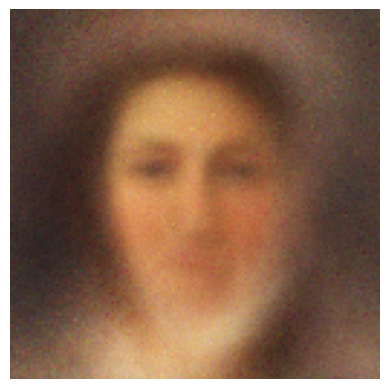

In [ ]:
plt.imshow((np.array(img[0])+1)/2)
plt.axis('off')
plt.show()

In [ ]:
num_images=16
x_gen=generate_latent_points(latent_dim,num_images)
gen_images=generator.predict(x_gen) # generating 16 images

1/1 [==============================] - 0s 68ms/step


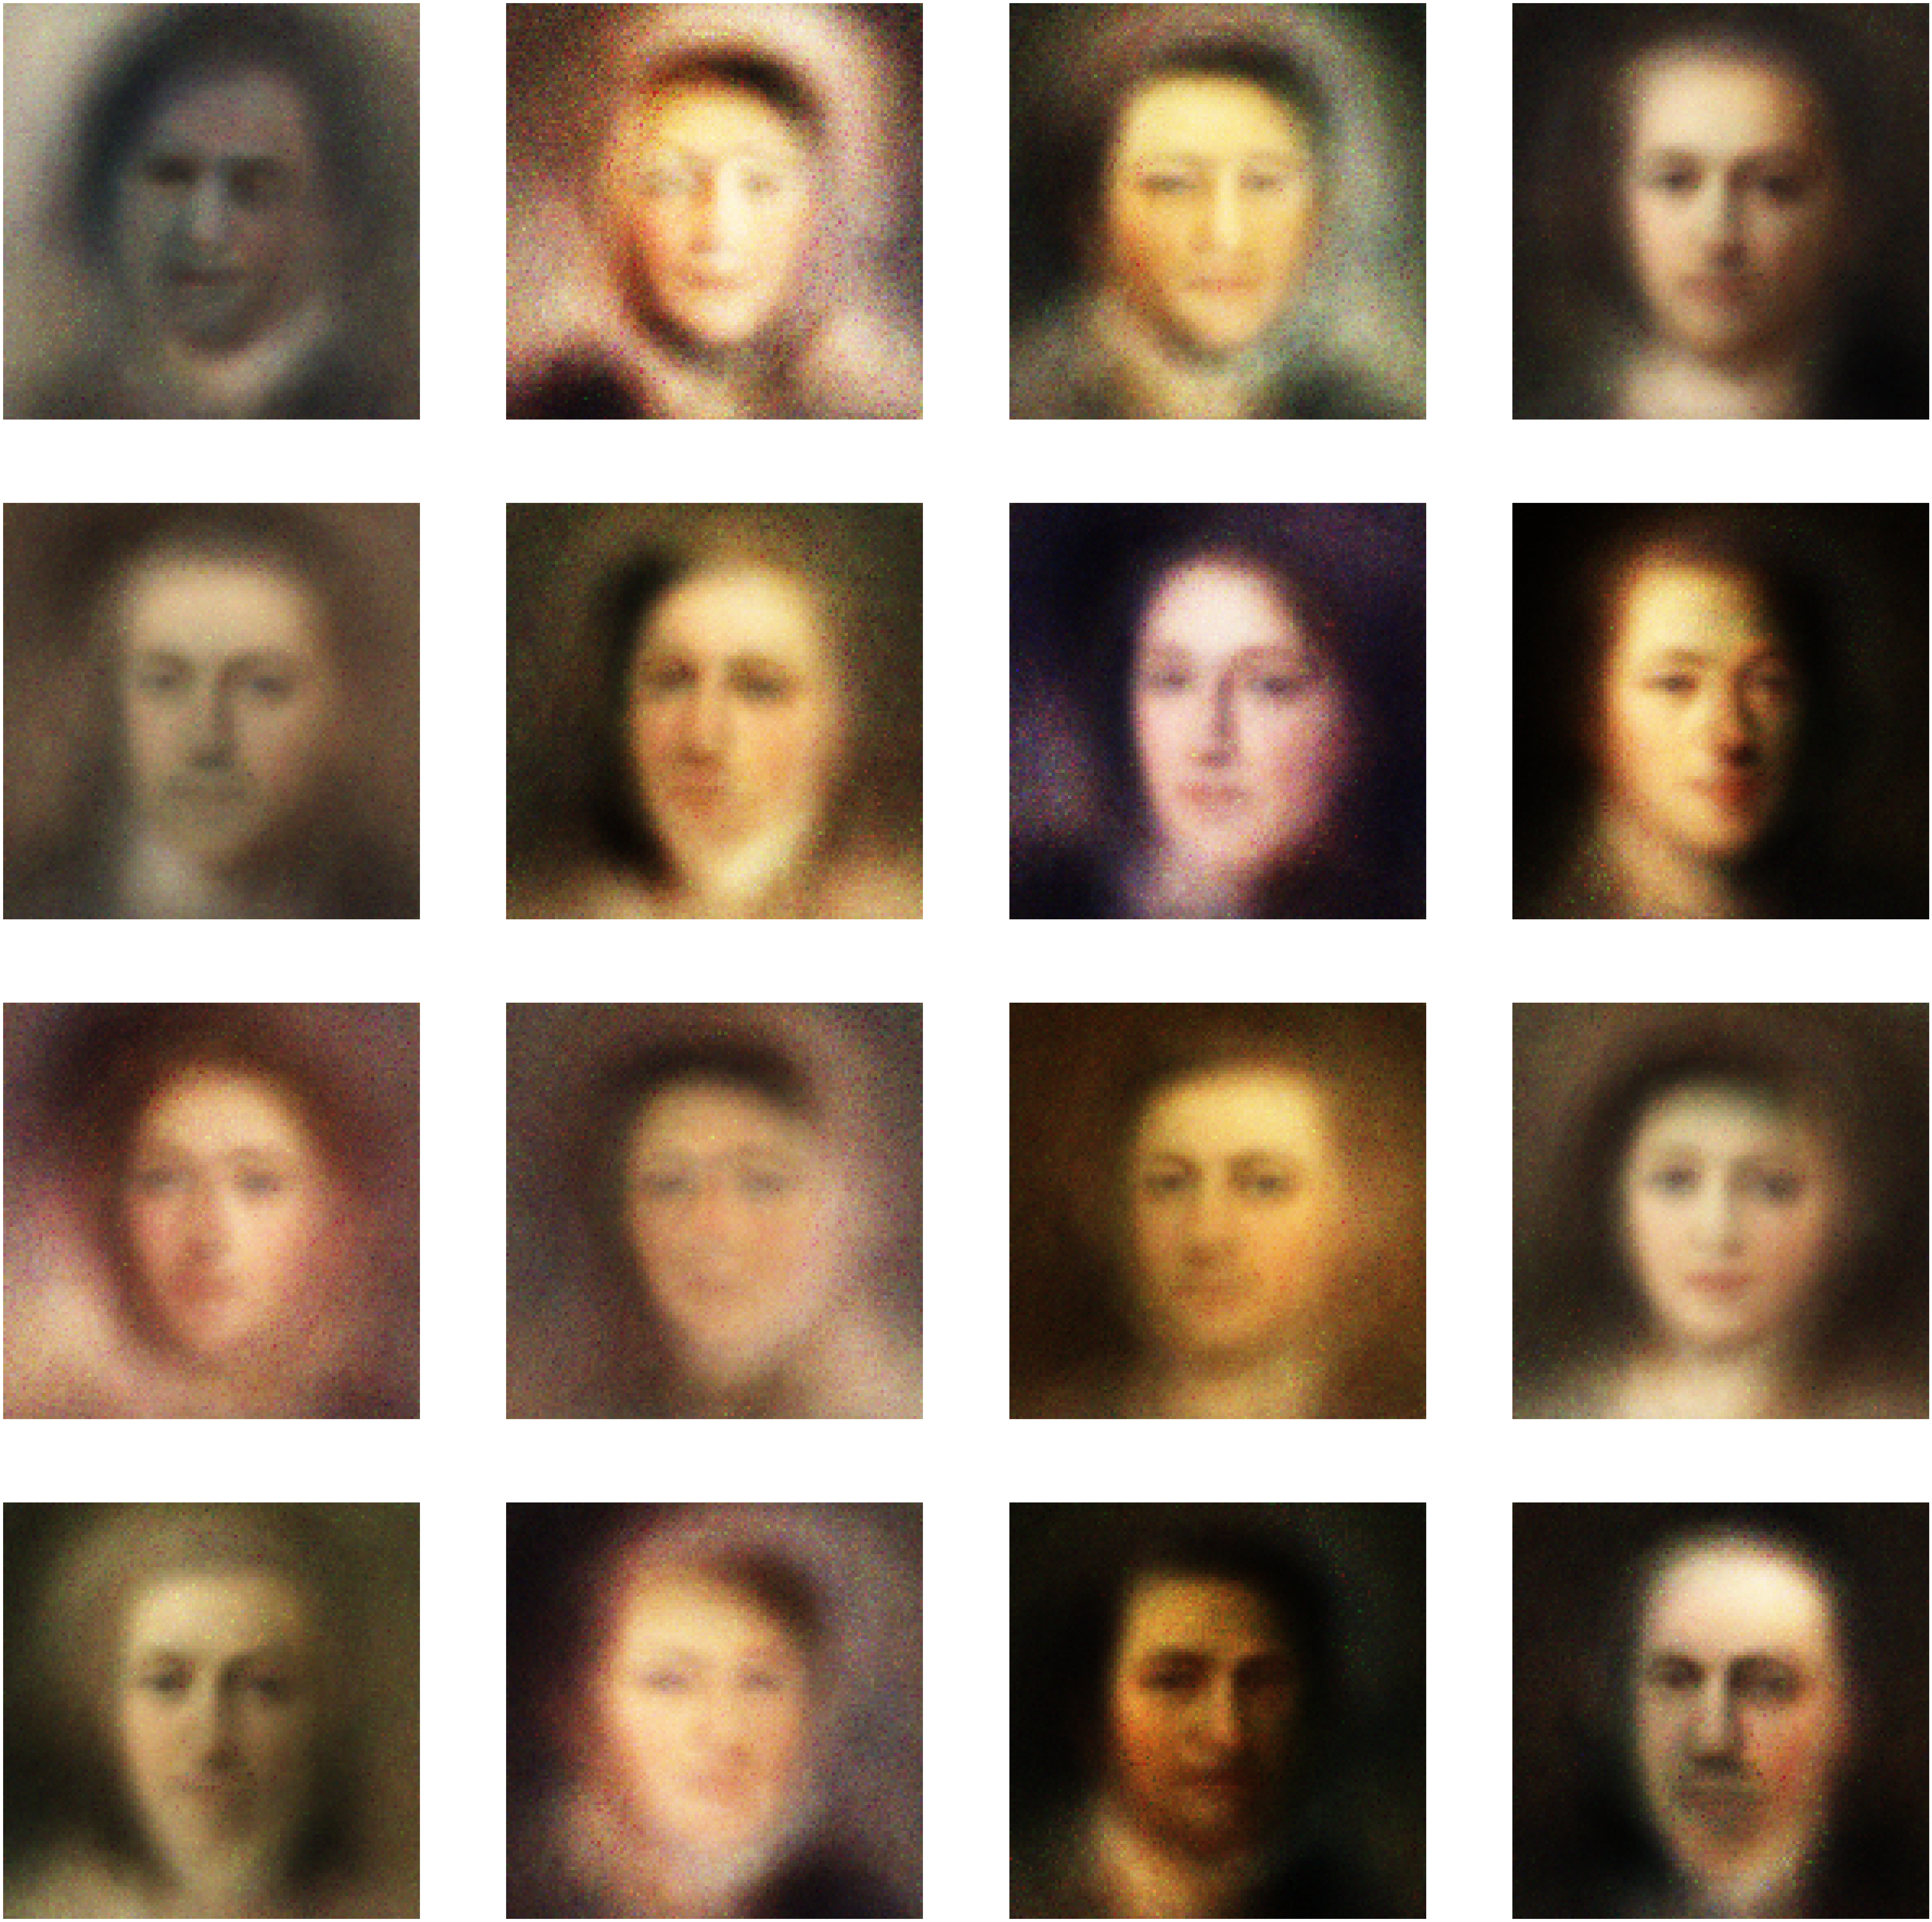

In [ ]:
plt.figure(figsize=(40,40))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow((gen_images[i]+1)/2)
plt.show()

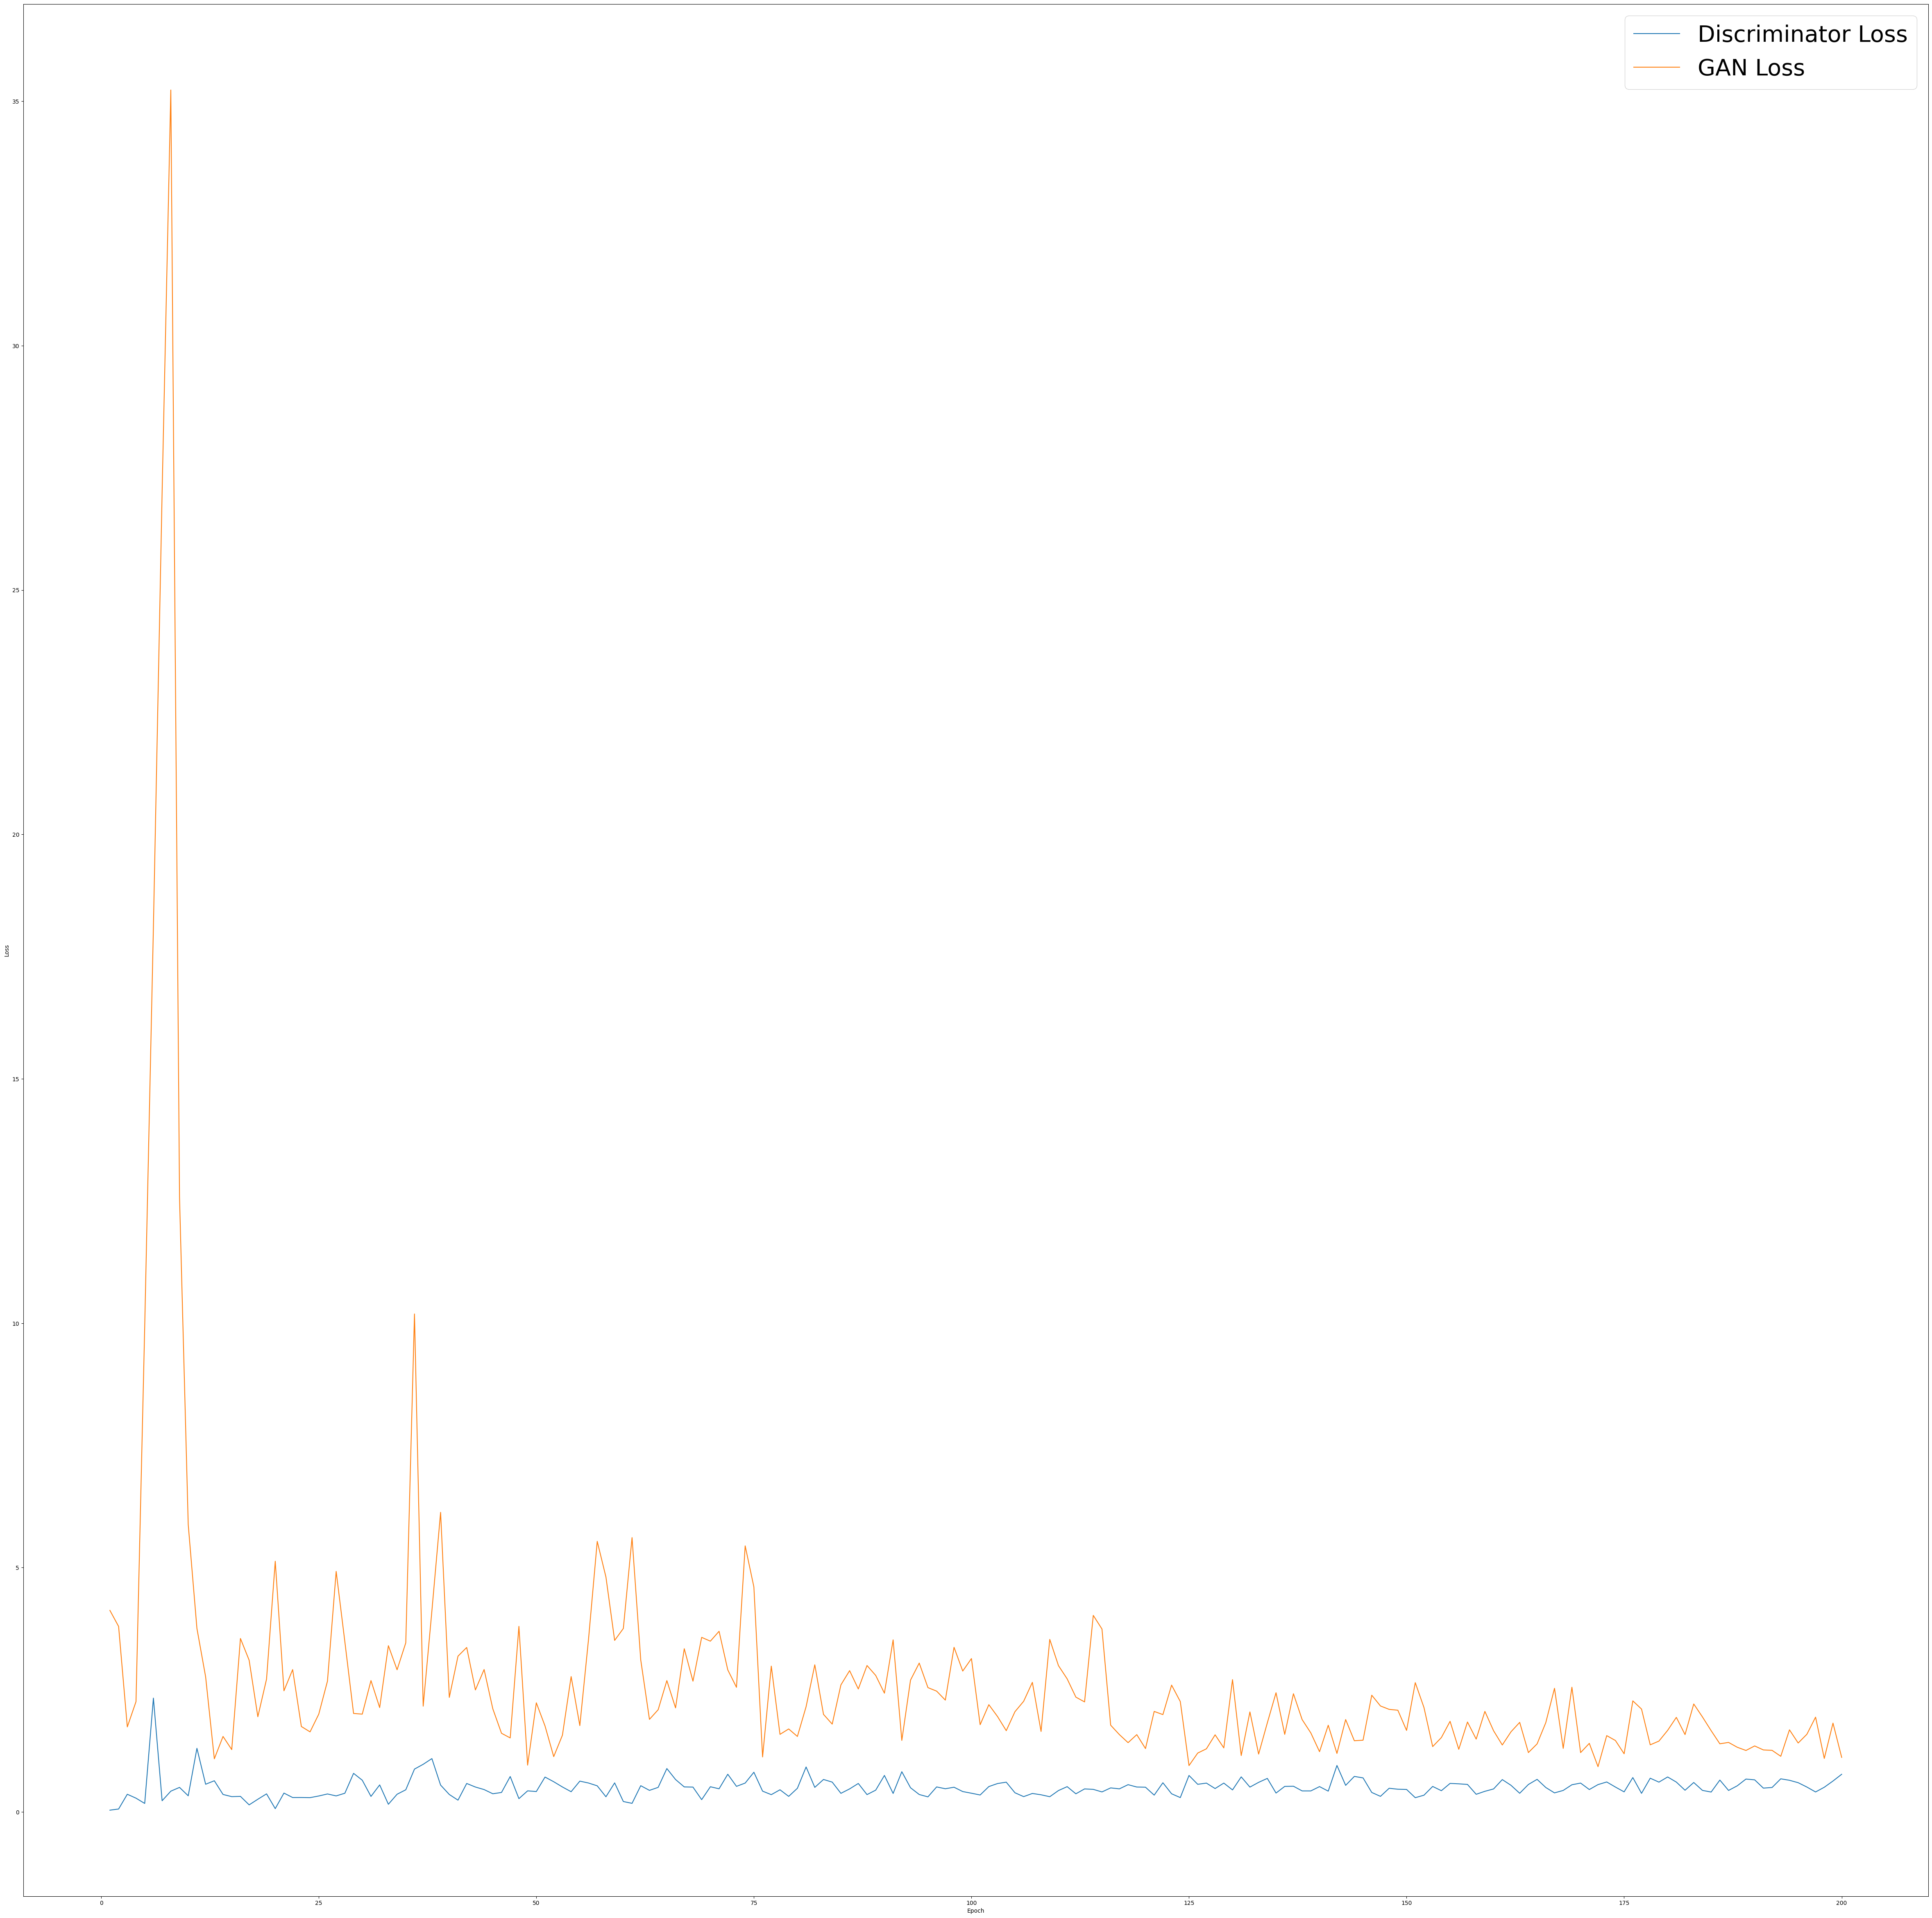

In [ ]:
x=np.arange(1,epoch+1)
plt.figure(figsize=(60,60))
plt.plot(x,d_loss,label='Discriminator Loss')
plt.plot(x,g_loss,label='GAN Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=40)
plt.show()

### Below is an illustration the training process of GAN. The generator is made to produce an image using the same latent vector each epoch

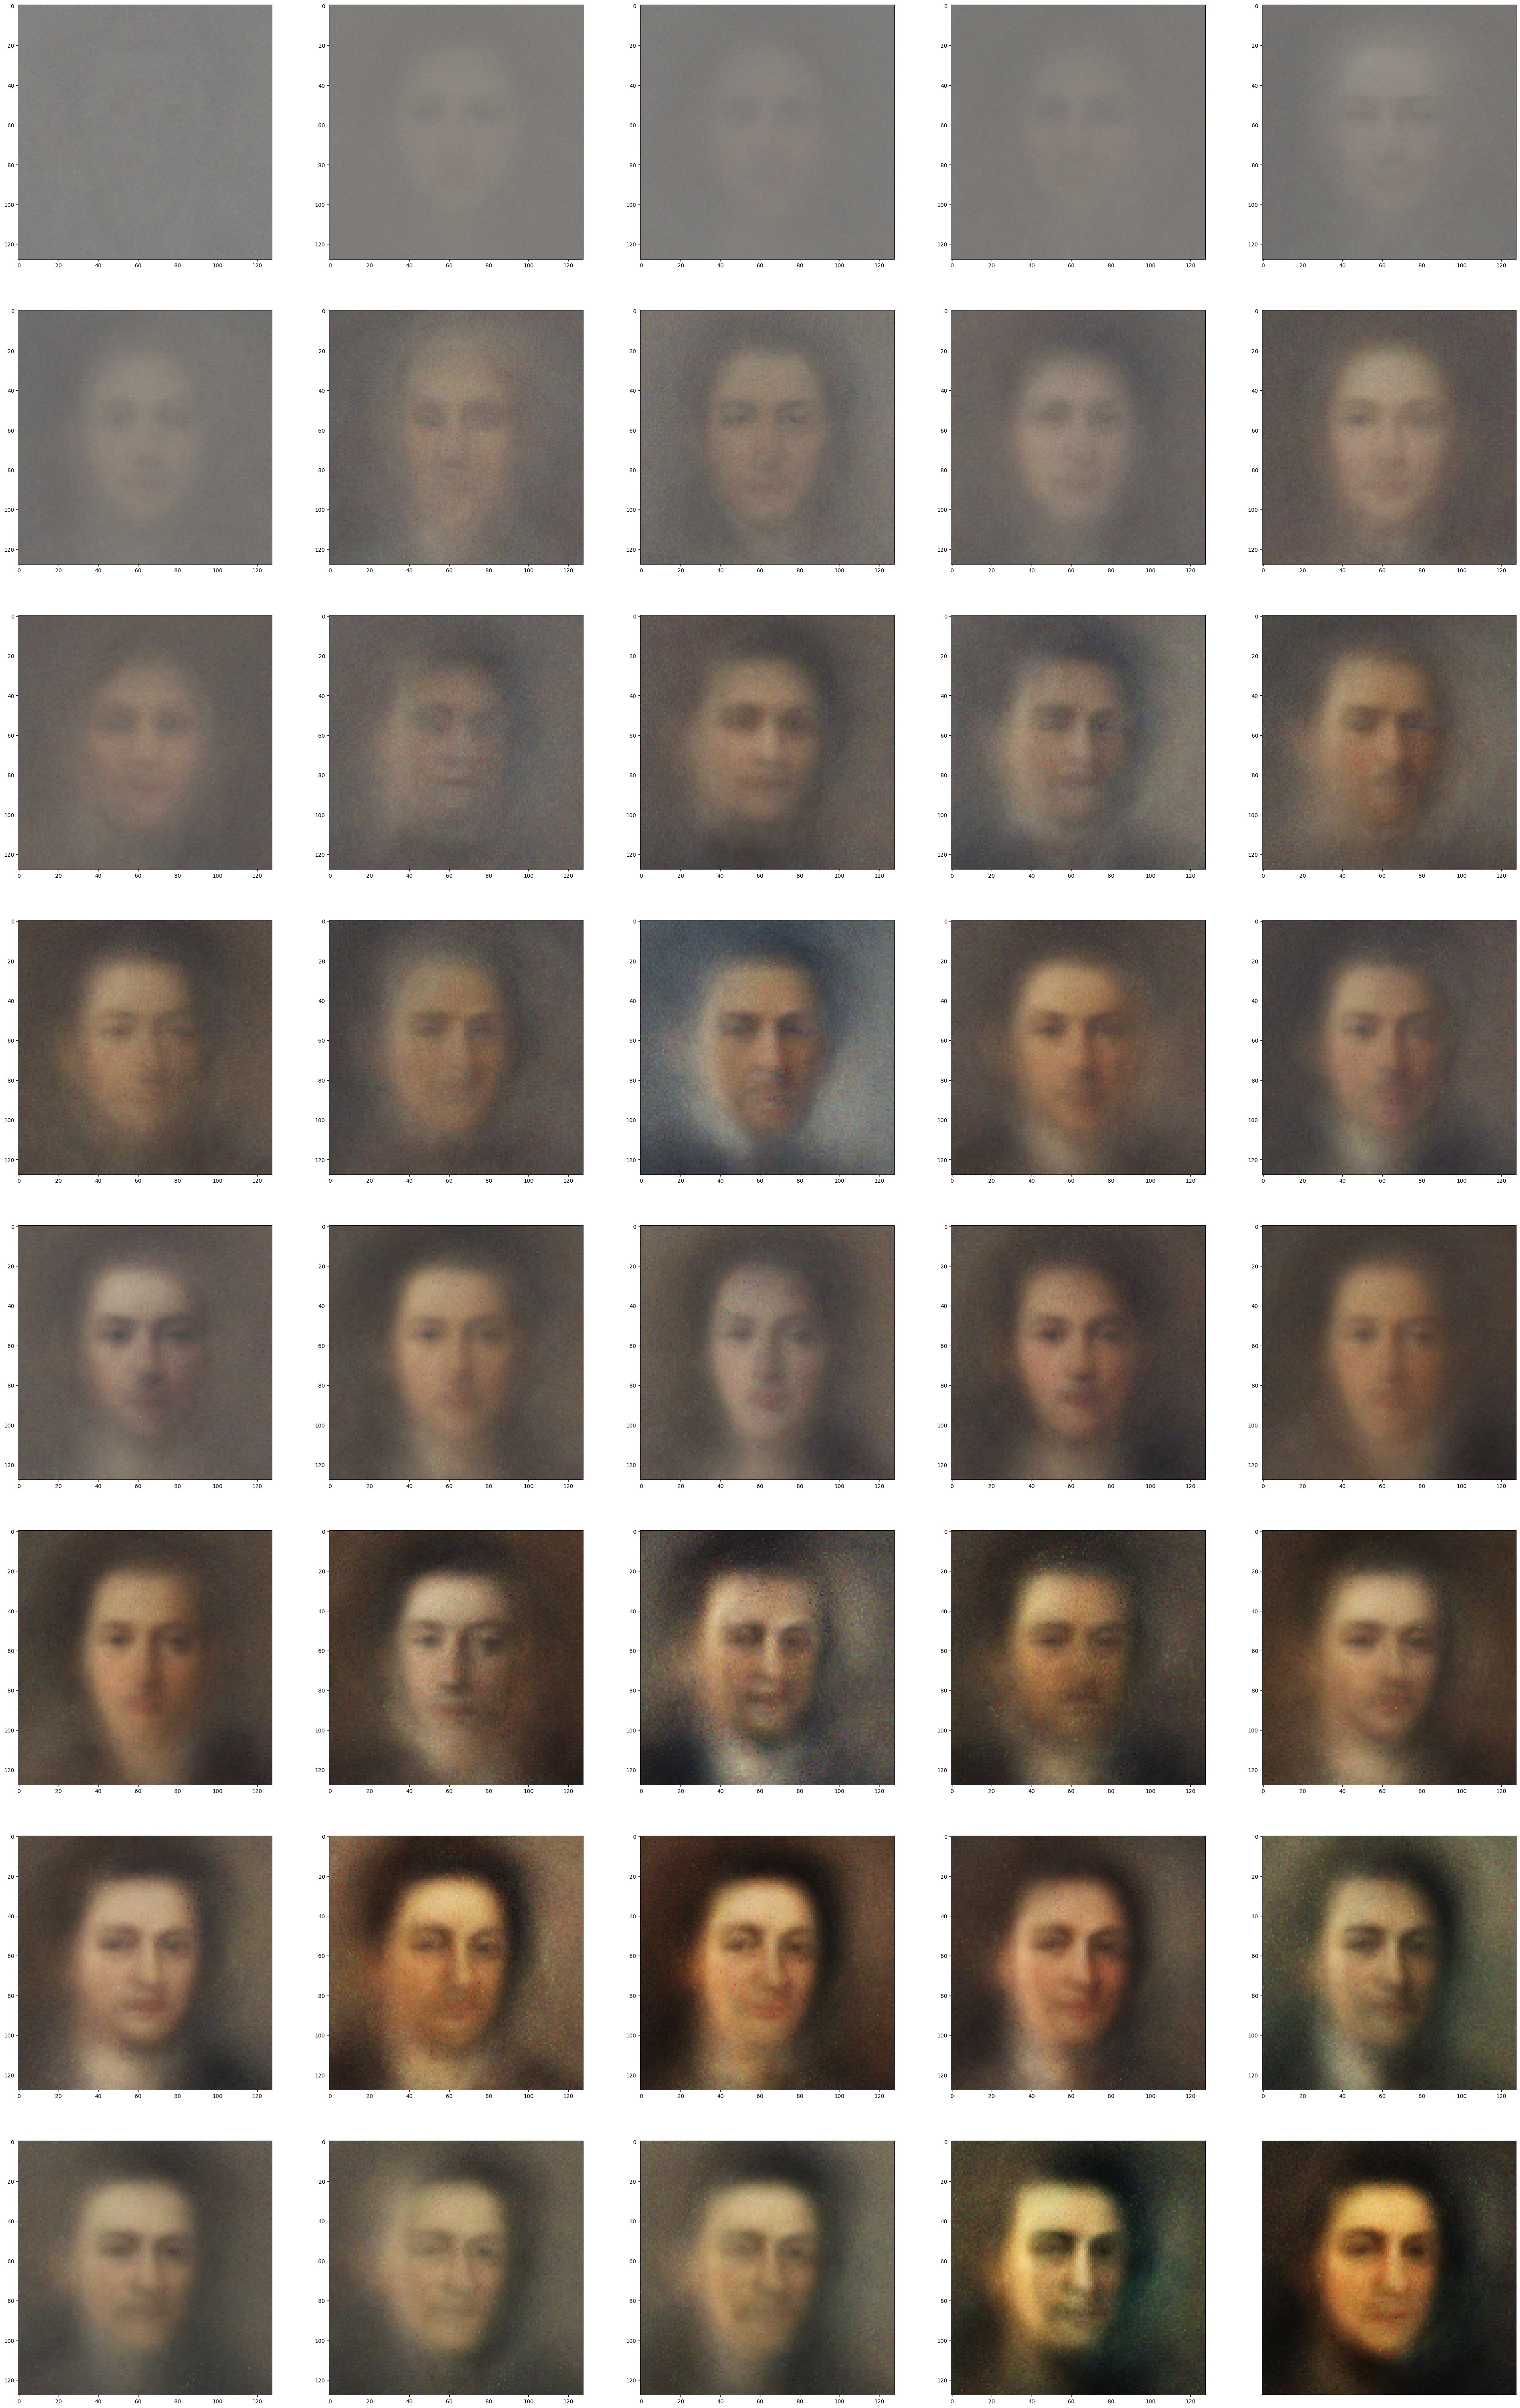